<a href="https://colab.research.google.com/github/sagihaider/IADS_SummerSchool_NN_2019/blob/master/Day2_3_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Recurrent Neural Networks (RNN)

* Densely connected networks and convnets:  **no memory**. 

* Each input shown to them is processed independently, with no state kept in between inputs. With such networks, bin order to process a sequence or a temporal series of data points, you have to show the entire sequence to the network at once: turn it into a single data point. 

* For instance, this is what you did in the IMDB example: an entire movie review was transformed into a single large vector and processed in one go. Such networks are called
feedforward networks.


**How RNN Works?**

* As you’re reading the present sentence, you’re processing it word by word, while keeping memories of what came before; this gives you a fluid representation of the meaning conveyed by this sentence.

* Biological intelligence processes information incrementally while maintaining an internal model of what it’s processing, built from past information and constantly updated as new information comes in.

* RNN processes sequences by iterating through the sequence elements and maintaining a state containing information relative to what it has seen so far.

* RNN is a type of neural network that has an internal loop

**Note**: 

* The state of the RNN is reset between processing two different, independent sequences (such as two different IMDB reviews), so you still consider one sequence a single data point: a single input to the network. What changes is that this data point is no longer processed in a
single step; rather, the network internally loops over sequence elements.

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Images
!pwd
import warnings
warnings.filterwarnings('ignore')
from IPython.display import Image

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive/My Drive/Images
/gdrive/My Drive/Images


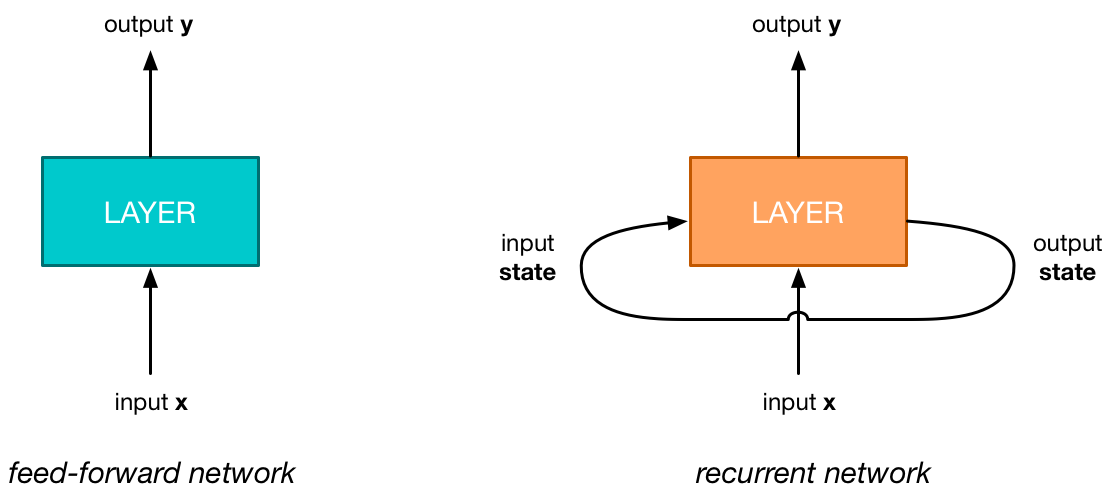

In [0]:
Image('RNNvsFF.png', width=600, height=300)
# Source: https://machinethink.net/blog/recurrent-neural-networks-with-swift/

In [0]:
# NumPy Implementation of RNN

import numpy as np

timesteps = 100
input_features = 32
output_features = 64

inputs = np.random.random((timesteps, input_features))
print(inputs.shape)

state_t = np.zeros((output_features,))
print(state_t.shape)

W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))

successive_outputs = []

for input_t in inputs:
  #print(input_t)
  output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b) # Combines the input with the current state (the previous output) to obtain the current output
  #print(output_t)
  successive_outputs.append(output_t) # Stores this output in a list
  #print(successive_outputs)
  state_t = output_t #Updates the state of the network for the next timestep
  
final_output_sequence = np.concatenate(successive_outputs, axis=0) # The final output is a 2D tensor of shape (timesteps, output_features).

(100, 32)
(64,)


### A Recurrent layer in Keras

The process you just naively implemented in Numpy corresponds to an actual Keras layer—the SimpleRNN layer:


In [0]:
from keras.layers import SimpleRNN

Using TensorFlow backend.


There is one minor difference: SimpleRNN processes batches of sequences, like all other Keras layers, not a single sequence as in the Numpy example. This means it takes inputs of shape `(batch_size, timesteps, input_features)`, rather than `(timesteps, input_features)`.


Like all recurrent layers in Keras, SimpleRNN can be run in two different modes: 

* It can return either the full sequences of successive outputs for each timestep (a 3D tensor
of shape (batch_size, timesteps, output_features))

* Or only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). 

These two modes are controlled by the return_sequences constructor argument. Let’s look
at an example that uses SimpleRNN and returns only the output at the last timestep:

In [0]:
import warnings
warnings.filterwarnings('ignore')

from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

Using TensorFlow backend.
W0730 09:11:38.058984 140132975490944 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0730 09:11:38.076382 140132975490944 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0730 09:11:38.079216 140132975490944 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [0]:
# The following example returns the full state sequence:

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


## Example: IMDB movie-review-classification problem



In [3]:
from keras.datasets import imdb
from keras.preprocessing import sequence
import numpy as np

max_features = 10000
maxlen = 500
batch_size = 32
print('Loading data...')

# This is the trick due to new version
# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

# call load_data with allow_pickle implicitly set to true
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)

# restore np.load for future normal usage
np.load = np_load_old

print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')
print('Pad sequences (samples x time)')

input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...
17465344/17464789 [==============================] - 2s 0us/step
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


In [0]:
# Training the model with Embedding and SimpleRNN layers

from keras.layers import Dense
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

W0730 09:28:07.768160 140132975490944 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0730 09:28:07.787576 140132975490944 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0730 09:28:07.794136 140132975490944 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 322,113
Trainable params: 322,113
Non-trainable params: 0
_________________________________________________________________


W0730 09:28:08.187895 140132975490944 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 17s 857us/step - loss: 0.6457 - acc: 0.6109 - val_loss: 0.4827 - val_acc: 0.7814
Epoch 2/10
20000/20000 [==============================] - 16s 814us/step - loss: 0.5112 - acc: 0.7597 - val_loss: 0.4053 - val_acc: 0.8272
Epoch 3/10
20000/20000 [==============================] - 16s 811us/step - loss: 0.3233 - acc: 0.8674 - val_loss: 0.4777 - val_acc: 0.7684
Epoch 4/10
20000/20000 [==============================] - 16s 812us/step - loss: 0.2538 - acc: 0.8994 - val_loss: 0.3294 - val_acc: 0.8724
Epoch 5/10
20000/20000 [==============================] - 16s 814us/step - loss: 0.2001 - acc: 0.9241 - val_loss: 0.3565 - val_acc: 0.8650
Epoch 6/10
20000/20000 [==============================] - 16s 813us/step - loss: 0.1450 - acc: 0.9485 - val_loss: 0.4081 - val_acc: 0.8450
Epoch 7/10
20000/20000 [==============================] - 16s 818us/step - loss: 0.0945 - acc: 0.9688 - val_loss: 0.4

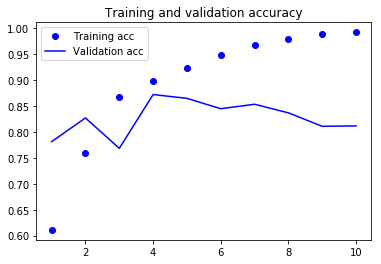

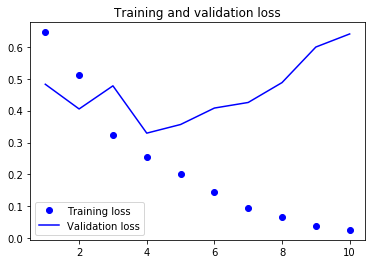

In [0]:
# Let's plot the results

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Gated Reccurrent Unit (GRU) and Long Short-Term Memory (LSTM)\

SimpleRNN has a major issue: although it should theoretically be able to retain at time `t` information about inputs seen many timesteps before, in practice, such long-term dependencies are impossible to learn. This is due to the *vanishing gradient problem,* an effect that is similar to what is observed with non-recurrent networks (feedforward networks) that are many layers deep: as you keep adding layers
to a network, the network eventually becomes untrainable. 

[Want to explore more about vanishing gradient](https://www.youtube.com/watch?v=SKMpmAOUa2Q) Click on this link

The LSTM and GRU layers are designed to solve this problem.

### LSTM

It adds a way to carry information across many timesteps. 

* Imagine a conveyor belt running parallel to the sequence you’re processing. 
* Information from the sequence can jump onto the conveyor belt at any point, be transported to a later timestep, and jump off, intact, when you need it. 
* This is essentially what LSTM does: it saves information for later, thus preventing older signals from gradually vanishing during processing.

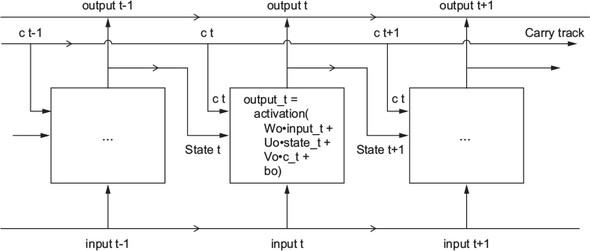

In [19]:
Image('LSTM1.jpg', width=600, height=250)
# Source: deep-learning-with-Python (Book)

In [20]:
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(input_train, y_train, 
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 328,353
Trainable params: 328,353
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 72s 4ms/step - loss: 0.5096 - acc: 0.7611 - val_loss: 0.4258 - val_acc: 0.8250
Epoch 2/10
20000/20000 [==============================] - 72s 4ms/step - loss: 0.2900 - acc: 0.8868 - val_loss: 0.3111 - val_acc: 0.8664
Epoch 3/10
20000/20000 [==============================] - 72s 4ms/step - loss

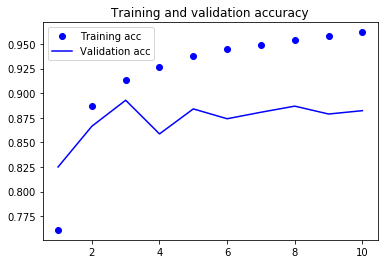

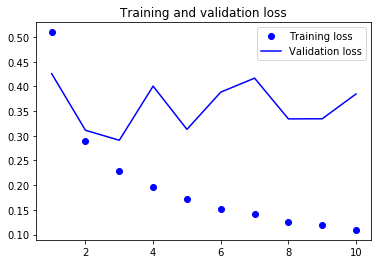

In [21]:
# Let's plot the results

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Advance LSTM

In [4]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb

max_features = 10000
# cut texts after this number of words (among top max_features most common words)
maxlen = 80
batch_size = 32

print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(input_train, y_train,
          batch_size=batch_size,
          epochs=15,
          validation_data=(input_test, y_test))
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

W0730 13:55:32.012177 140497869289344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0730 13:55:32.046322 140497869289344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0730 13:55:32.051806 140497869289344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0730 13:55:32.146170 140497869289344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0730 13:55:32.154963 

Build model...


W0730 13:55:32.401250 140497869289344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0730 13:55:32.421341 140497869289344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0730 13:55:32.427350 140497869289344 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/15
16928/25000 [===================>..........] - ETA: 3:11 - loss: 0.5093 - acc: 0.7469

KeyboardInterrupt: ignored